In [1]:
library(dplyr) # filter
library(ggplot2)
library(ggpubr) # ggarange
library(ggnewscale) # new_scale_fill
options(warn=-1)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
rm(list = ls())
source('../tools.R')
source('../FLAG.R')

set.seed(1234)
m = 10
pblock = 40
P = m + pblock
N = 200

theta = 0.3
Theta_aa = matrix(c(1, theta, theta, 1), 2, 2)

pi=0.3

ratio = c(1, 0.9, 1, 0.7, 1, 0.5, 1, 0.3, 1, 0.1)
Pre = matrix(0, P, P)

k=0
while(T){
  k=k+1
  # beta:
  delta = 0.2
  Gamma_beta = matrix(delta, m, m)
  diag(Gamma_beta) = 0.8
  
  nonzero = NULL
  for(i in 1:m){
    nonzero = cbind(nonzero, matrix(rbinom((P-2), 1, ratio[i]), nrow = (P-2), ncol=1))
  }
  
  beta = MASS::mvrnorm((P-2), rep(0,m), Gamma_beta) * nonzero
  
  # generate precision matrix
  pair.num=as.integer(m/2)
  for(k in 1:pair.num){
      i=2*k-1
      j=2*k
      Pre[c(i,j), c(i,j)]=Theta_aa
      Theta_ba=-beta[,c(i,j)]%*%Theta_aa
      
      # overlap fixed as zero, only update dim>m
      Pre[(m+1):P, c(i,j)]=Theta_ba[(m-2+1):(P-2),]
      
      # Symmetrization
      Pre[c(i,j), -c(i,j)]=t(Pre[-c(i,j), c(i,j)])
  }
  
  block = matrix(rbinom(pblock*pblock, 1, pi)*runif(pblock*pblock, 3, 5), nrow = pblock, ncol = pblock )
  block[lower.tri(block)]=t(block)[lower.tri(block)]
  diag(block) = 50

  Pre[(m+1):(m+pblock), (m+1):(m+pblock)]=block
  
  values = eigen(Pre)$values
  # check if Pre is positive definite
  if(all(values > 0.001)){
    cat('Succeed.')
    break
  } 
  if(k>1000){
    cat('Failed.')
    break
  }
}


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




Succeed.

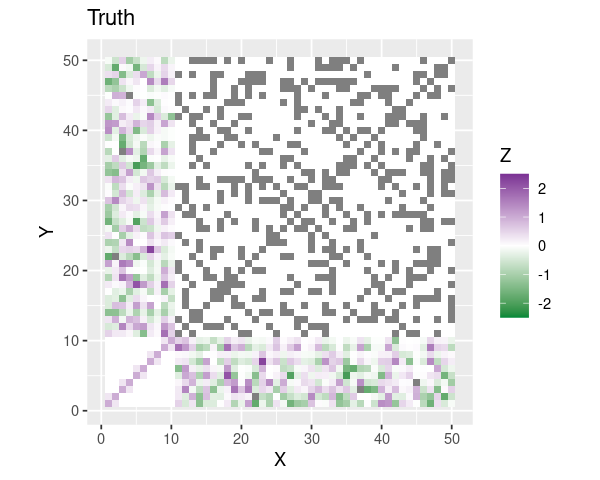

In [3]:
options(repr.plot.width=5, repr.plot.height=4)
X=Y=1:P
df=expand.grid(X=X, Y=Y)

df$Z=c(Pre)
ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('Truth') + coord_fixed() +
        scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-2.5, 2.5))

In [4]:
# Generate data
Z = MASS::mvrnorm(N, rep(0, P), solve(Pre))
Z = scale(Z, center = T, scale = F)

# run methods
MLE = run.mle(Z)
CLIME = run.clime(Z)
OM = OurMethod(Z)
ANT = run.ant(Z)
BGGM = run.bggm(Z)
GLASSO = run.glasso(Z)
HGL = run.hglasso(Z)
DSGL = run.dsglasso(Z)

Allocating memory 
start recovering 
preparing precision and path matrix list 
Done! 
Some columns do not reach the required lambda!
 You may want to increase lambda.min or use a larger nlambda. 


Registered S3 methods overwritten by 'BFpack':
  method               from
  get_estimates.lm     bain
  get_estimates.t_test bain

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



  |======================================================================| 100%
Optimal tuning parameter on boundary... consider providing a smaller lam value or decreasing lam.min.ratio!Use method '"D-S_GL"'
Use default lambda = sqrt(log(p)/n)
In this case, lambda = 0.139857
Center each column.
Pre-calculate inner product matrixes.
Calculate graphical Lasso.


In [5]:
# get (estimated) precision matrices
true.prec = Pre
MLE.prec = MLE
CLIME.prec = CLIME$icov
OM.prec = OM$precision.est
ANT.prec = ANT$precision
BGGM.prec = BGGM$precision
GLASSO.prec = GLASSO$wi
HGL.prec = HGL$Theta
DSGL.prec = DSGL$precision

In [6]:
get.heatmap <- function(dim, value, title, hub.num, bound1=3.2){
  X=Y=1:dim
  df=expand.grid(X=X, Y=Y)
  df$Z = c(value)

  categ = matrix(1, dim, dim)
  categ[(hub.num+1):dim, (hub.num+1):dim] = 2
  df$category = c(categ)

  ggplot() +
  geom_raster(data = filter(df, category == 1), aes(X, Y, fill = Z)) +
  scale_fill_gradient2(low="#008837", high="#7b3294", mid="white", midpoint=0, name="Block A&B", limits=c(-bound1,bound1)) +
  new_scale_fill() +
  geom_raster(data = filter(df, category == "2"), aes(X, Y, fill = Z)) +
  scale_fill_gradient2(low = "darkblue", high = "darkred", mid="white", midpoint=0, name = "Block C", limits=c(-2, 55)) +
  ggtitle(title) + coord_fixed() + xlab(NULL) + ylab(NULL)
}

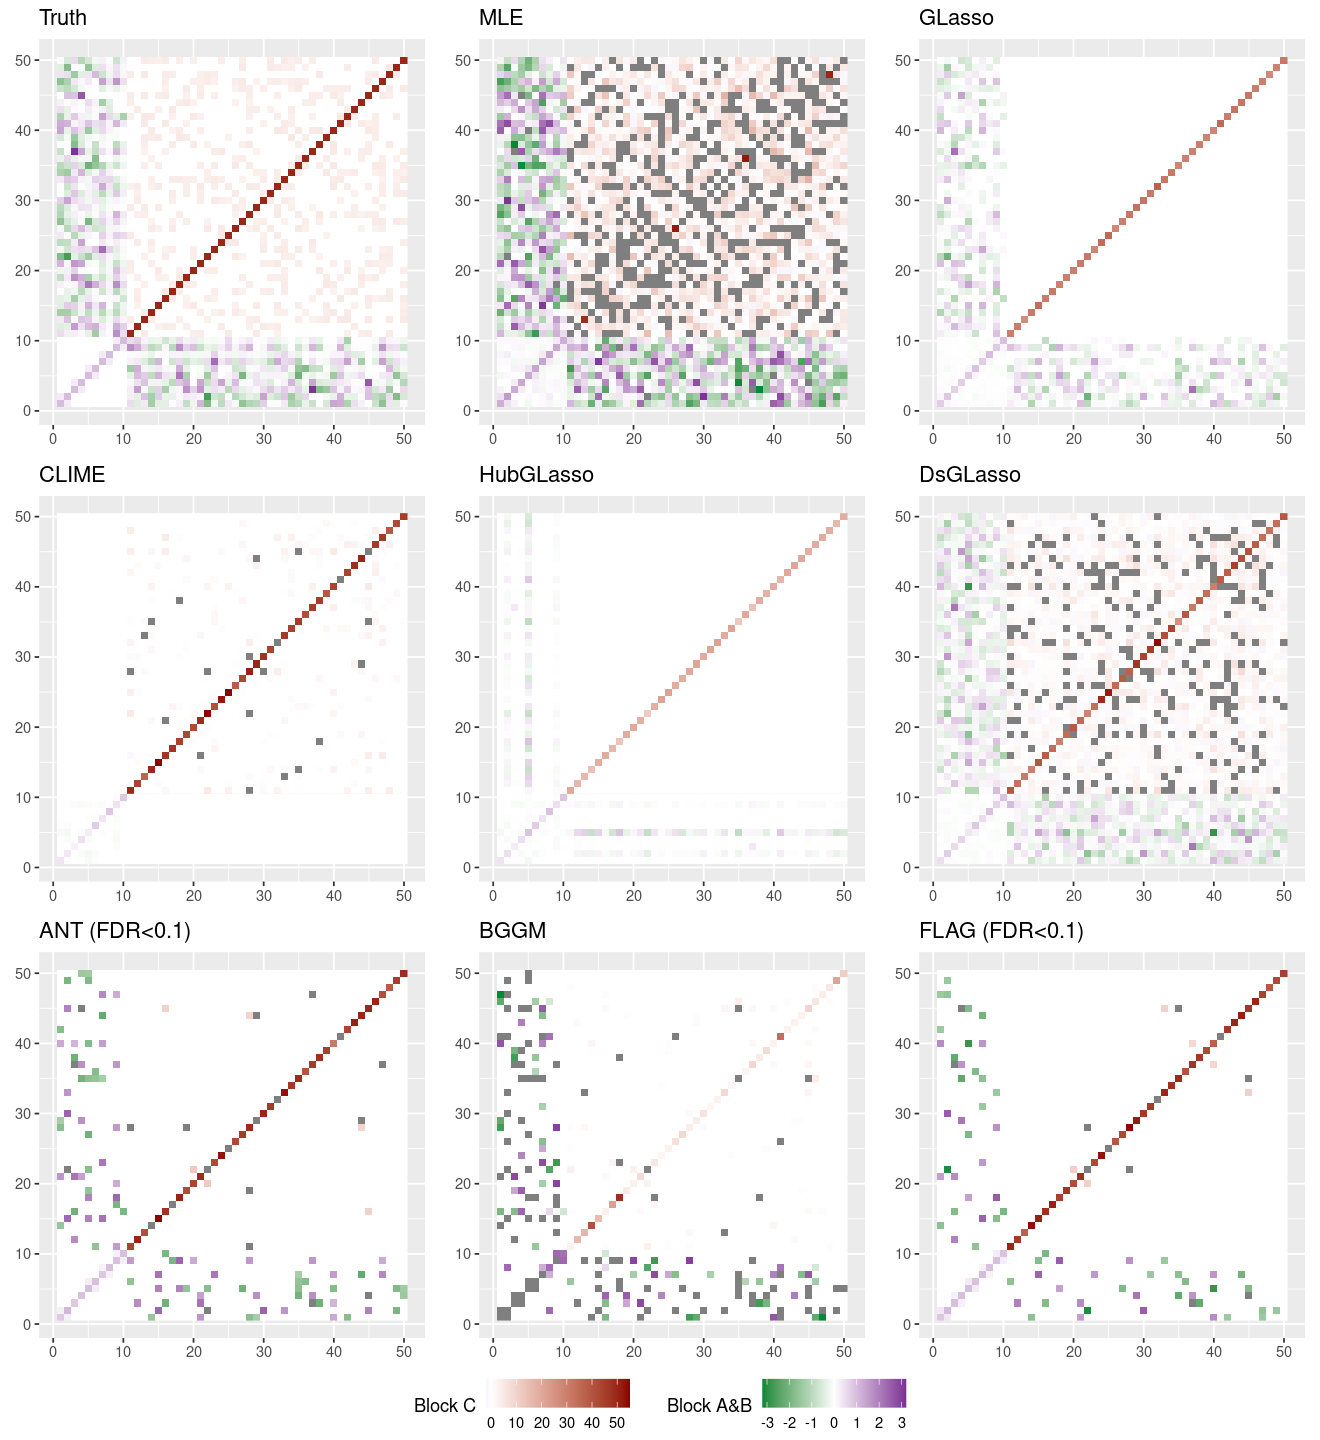

In [7]:
om.adj = get.fdr(OM$precision.pval, diag.val=1)
ant.adj = get.fdr(ANT$p_precision, diag.val=1)
bggm.adj = get.adj(BGGM$edge, diag.val=1)
options(repr.plot.width=11, repr.plot.height=12)
p1=get.heatmap(P, true.prec, 'Truth', m)
p2=get.heatmap(P, MLE.prec, 'MLE', m)
p3=get.heatmap(P, CLIME.prec, 'CLIME', m)
p4=get.heatmap(P, OM.prec * om.adj, 'FLAG (FDR<0.1)', m)
p5=get.heatmap(P, ANT.prec * ant.adj, 'ANT (FDR<0.1)', m)
p6=get.heatmap(P, BGGM.prec * bggm.adj, 'BGGM', m)
p7=get.heatmap(P, GLASSO.prec, 'GLasso', m)
p8=get.heatmap(P, HGL.prec, 'HubGLasso', m)
p9=get.heatmap(P, DSGL.prec, 'DsGLasso', m)
# ggarrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=3, nrow=3, common.legend = TRUE, legend="bottom")
ggarrange(p1, p2, p7, p3, p8, p9, p5, p6, p4, ncol=3, nrow=3, common.legend = TRUE, legend="bottom")